In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# !pip install transformers

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
# BASE_PATH = "/content/drive/My Drive/collab/MIMIC/"
BASE_PATH = "/Users/samir/Dev/projects/MIMIC/MIMIC/"
INPUT_PATH = BASE_PATH+"/DATA/input/"
FEATURES_PATH = BASE_PATH+"/DATA/features/"
OUTPUT_PATH = BASE_PATH+"/DATA/results/"
TMP_PATH = BASE_PATH+"/DATA/processed/"

TUNE_OUTPUT_PATH = BASE_PATH+"/DATA/tune_results/"
TUNE_TMP_PATH = BASE_PATH+"/DATA/tune_processed/"


sys.path.append("/content/drive/My Drive/collab/TADAT/") 

#configs
N_SEEDS=5
N_VAL_SEEDS = 4
N_VAL_RUNS = 4
N_TASKS = 3
# N_TASKS = 50
# PLOT_VARS=["auroc","auprc","sensitivity","specificity"]
PLOT_VARS=["auroc","sensitivity"]
MODEL="BERT-POOL"

GROUPS = { "GENDER": ["M"],
         "ETHNICITY_BINARY": ["WHITE","NON-WHITE"],
         "ETHNICITY": ["WHITE","BLACK","ASIAN","HISPANIC"]
}
MAJORITY_GROUP = { "GENDER": "M",
                   "ETHNICITY_BINARY": "WHITE",
                    "ETHNICITY": "WHITE" }
CLASSIFIER = 'sklearn'
CLASSIFIER = 'torch'

In [3]:
from collections import defaultdict
from datetime import datetime
import dill
import fnmatch
import itertools
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import RandomState
import os
from pdb import set_trace
import pandas as pd
import pickle
import pprint
import random
from sklearn.linear_model import SGDClassifier 
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, auc, precision_recall_curve
from sklearn.metrics import precision_recall_fscore_support as score
import seaborn as sns
import warnings
import torch
import uuid
import time

#local
from tadat.pipeline import plots
from tadat.core import data, vectorizer, features, helpers, embeddings, berter, transformer_lms, transformer_encoders

warnings.filterwarnings("ignore")
sns.set(style="darkgrid")

# Modeling 

In [4]:
#torch model
class MyLinearModel(torch.nn.Module):
    def __init__(self, in_dim, out_dim, loss_fn, optimizer=None, 
                 default_lr=None, init_seed=None, n_epochs=4, 
                 batch_size=None, shuffle_seed=None, silent=False, 
                 shuffle=False, device=None):
        super().__init__()
        if not device: self.device = get_device(silent=True)
        self.batch_size = batch_size
        self.shuffle_seed = shuffle_seed
        self.shuffle = shuffle
        self.silent = silent
        self.loss_fn = loss_fn
        self.n_epochs = n_epochs
        self.model = torch.nn.Linear(in_dim, out_dim)
        if init_seed: 
            torch.manual_seed(init_seed)        
            #initialize random weights
            torch.nn.init.uniform_(self.model.weight, a=0.0, b=1.0)
        if optimizer:
            self.optimizer = optimizer(self.model.parameters())
        else:
            if default_lr:
                self.optimizer = torch.optim.Adam(self.model.parameters(), 
                                                  lr=default_lr)
            else:
                self.optimizer = torch.optim.Adam(self.model.parameters())

    def forward(self, in_dim, out_dim):
        return self.model(in_dim, out_dim)

    def fit(self, X_train, Y_train, X_val, Y_val):      
        X_train = torch.from_numpy(X_train.astype(np.float32))
        Y_train = torch.tensor(Y_train, dtype=torch.float32).reshape(-1, 1)
        X_val = torch.from_numpy(X_val.astype(np.float32))
        Y_val = torch.tensor(Y_val, dtype=torch.float32).reshape(-1, 1)

        train_len = X_train.shape[0]        
        rng = RandomState(self.shuffle_seed)        
        if not self.batch_size:        
            self.batch_size = train_len
            n_batches = 1
        else:
            n_batches = int(train_len/self.batch_size)+1            
        #send validation data and model to device
        X_val_ = X_val.to(self.device) 
        Y_val_ = Y_val.to(self.device)
        X_train_ = X_train.to(self.device)
        Y_train_ = Y_train.to(self.device)
        self.model = self.model.to(self.device) 
        idx = torch.tensor(rng.permutation(train_len))
        idx_ = idx.to(self.device) 

        train_losses = []
        val_losses = []
        val_loss_value=float('inf') 
        best_val_loss=float('inf')     
        n_val_drops=0   
        MAX_VAL_DROPS=10
        loss_margin = 1e-3      
        tmp_model_fname = str(uuid.uuid4())+".pt"
        if not self.silent: print("[tmp: {}]".format(tmp_model_fname))
        for it in range(self.n_epochs):    
            t0_epoch = time.time()
            if self.shuffle:                                     
                X_train_ = X_train[idx_].to(self.device)
                Y_train_ = Y_train[idx_].to(self.device)                        
                idx = torch.tensor(rng.permutation(train_len))
                idx_ = idx.to(self.device) 
            for j in range(n_batches):                
                x_train = X_train_[j*self.batch_size:(j+1)*self.batch_size, :]
                y_train = Y_train_[j*self.batch_size:(j+1)*self.batch_size]                
                y_hat_train = self.model(x_train)
                train_loss = self.loss_fn(y_hat_train, y_train)                
                train_loss_value = train_loss.item()
                self.optimizer.zero_grad()
                train_loss.backward()
                self.optimizer.step()                
                train_losses.append(train_loss_value)        
                val_losses.append(val_loss_value)   
            outputs_val = self.model(X_val_)
            val_loss = self.loss_fn(outputs_val, Y_val_)      
            val_loss_value =  val_loss.item()     
            if val_loss_value < best_val_loss:    
                n_val_drops=0            
                best_val_loss = val_loss
                #save best model
                # print("[updating best model]")
                torch.save(self.model.state_dict(), tmp_model_fname)
            elif val_loss_value > best_val_loss - loss_margin:                
                n_val_drops+=1
                # if n_val_drops == MAX_VAL_DROPS:
                #     print("[early stopping: {} epochs]".format(it))
                    # break
            if (it + 1) % 50 == 0 and not self.silent:
                time_elapsed = time.time() - t0_epoch
                print(f'[Epoch {it+1}/{self.n_epochs} | Training loss: {train_loss_value:.4f} | Val loss: {val_loss_value:.4f} | ET: {time_elapsed:.2f}]')
        self.model.load_state_dict(torch.load(tmp_model_fname))
        os.remove(tmp_model_fname)
        # self.model = self.model.cpu()
        return train_losses, val_losses  

    def predict_proba(self, X):        
        X = torch.from_numpy(X.astype(np.float32))
        X_ = X.to(self.device)        
        self.model = self.model.to(self.device) 

        with torch.no_grad():
            y_hat_prob = torch.nn.functional.sigmoid(self.model(X_))
            y_hat_prob =  y_hat_prob.cpu().numpy()
        return y_hat_prob

    def predict(self, X):        
        y_hat_prob = self.predict_proba(X)
        threshold = 0.5 
        y_hat = (y_hat_prob > threshold)
        return y_hat

def get_device(silent=False):
    if torch.cuda.is_available():       
        device = torch.device("cuda")
        if not silent:            
            print('GPU device name:', torch.cuda.get_device_name(0))
    else:
        device = torch.device("cpu")
        if not silent:
            print('No GPU available, using the CPU instead.')        
    return device

In [5]:
def train_classifier(X_train, Y_train, X_val, Y_val, 
                     init_seed, shuffle_seed=None, input_dimension=None):    
    if CLASSIFIER == "torch":        
        x = MyLinearModel(in_dim=input_dimension, out_dim=1, 
                    loss_fn=torch.nn.BCEWithLogitsLoss(), 
                    init_seed=init_seed, n_epochs=500, 
                    default_lr=0.001, batch_size=512, 
                    shuffle_seed=shuffle_seed, silent=True,
                    shuffle=True) 
        x.fit(X_train, Y_train, X_val, Y_val)
    elif CLASSIFIER == "sklearn":
        x = SGDClassifier(loss="log", random_state=shuffle_seed)
        x.fit(X_train, Y_train)
    else:
        raise NotImplementedError
    return x

def evaluate_classifier(model, X_test, Y_test,
                   labels, model_name, random_seed, res_path=None):
    Y_hat = model.predict(X_test)
    Y_hat_prob = model.predict_proba(X_test)
    #get probabilities for the positive class
    if CLASSIFIER == 'sklearn':
        Y_hat_prob = Y_hat_prob[:,labels[1]]    
    microF1 = f1_score(Y_test, Y_hat, average="micro") 
    macroF1 = f1_score(Y_test, Y_hat, average="macro") 
    try:
        aurocc = roc_auc_score(Y_test, Y_hat_prob)
    except ValueError:
        aurocc = 0
    try:
        prec, rec, thresholds = precision_recall_curve(Y_test, Y_hat)
        auprc = auc(rec, prec)
    except ValueError:
        auprc = 0
    try:
        tn, fp, fn, tp = confusion_matrix(Y_test, Y_hat).ravel()
        specificity = tn / (tn+fp)
        sensitivity = tp / (fn+tp)
    except ValueError:
        specificity, sensitivity = 0, 0
    
    res = {"model":model_name, 
            "seed":random_seed,    
            "microF1":round(microF1,3),
            "macroF1":round(macroF1,3),
            "auroc":round(aurocc,3),
            "auprc":round(auprc,3),
            "specificity":round(specificity,3),
            "sensitivity":round(sensitivity,3)           
            }

    if res_path is not None:    
        helpers.save_results(res, res_path, sep="\t")
    return res

def vectorize_train(df_train, df_val, subject_ids, feature_matrix):
    #vectorize labels
    train_Y = df_train["Y"]
    val_Y = df_val["Y"]           
    
    label_vocab = vectorizer.get_labels_vocab(train_Y+val_Y)
    train_Y,_ = vectorizer.label2idx(train_Y, label_vocab)
    val_Y,_ = vectorizer.label2idx(val_Y, label_vocab)
    
    #get the subject id indices
    train_idxs = [subject_ids.index(i) for i in list(df_train["SUBJECT_ID"])] 
    val_idxs = [subject_ids.index(i) for i in list(df_val["SUBJECT_ID"])] 
    
    #slice the feature matrix to get the corresponding instances
    train_feats = feature_matrix[train_idxs, :]
    val_feats = feature_matrix[val_idxs, :]    

    return train_feats, train_Y, val_feats, val_Y, label_vocab

def vectorize_test(df_test, subject_ids, feature_matrix, label_vocab, group_label, subgroup, subsample=False):
    #target subgroup vs others
    df_test_G = df_test[df_test[group_label] == subgroup]
    df_test_O = df_test[df_test[group_label] != subgroup]    
    
    if subsample and MAJORITY_GROUP[group_label] == subgroup:
        n_groups = len(GROUPS[group_label])
        avg_len = int(len(df_test_O)/n_groups)
        df_test_G = df_test_G.head(avg_len)

    print("{}: {} | others: {}".format(subgroup,
                                       len(df_test_G),len(df_test_O)))        
    #vectorize labels           
    test_Y = df_test["Y"]
    test_Y_G = df_test_G["Y"]
    test_Y_O = df_test_O["Y"]               
    test_Y,_ = vectorizer.label2idx(test_Y, label_vocab)
    test_Y_G,_ = vectorizer.label2idx(test_Y_G, label_vocab)
    test_Y_O,_ = vectorizer.label2idx(test_Y_O, label_vocab)
    #get the subject id indices    
    test_idxs = [subject_ids.index(i) for i in list(df_test["SUBJECT_ID"])] 
    test_idxs_G = [subject_ids.index(i) for i in list(df_test_G["SUBJECT_ID"])] 
    test_idxs_O = [subject_ids.index(i) for i in list(df_test_O["SUBJECT_ID"])] 
    #slice the feature matrix to get the corresponding instances    
    test_feats = feature_matrix[test_idxs, :]
    test_feats_G = feature_matrix[test_idxs_G, :]
    test_feats_O = feature_matrix[test_idxs_O, :]  

    return test_feats, test_Y, test_feats_G, test_Y_G, test_feats_O, test_Y_O

def get_features(data, vocab_size, feature_type, word_vectors=None):
    if feature_type == "BOW-BIN":
        X = features.BOW(data, vocab_size,sparse=True)
    elif feature_type == "BOW-FREQ":
        X = features.BOW_freq(data, vocab_size,sparse=True)
    elif feature_type == "BOE-BIN":
        X = features.BOE(data, word_vectors,"bin")
    elif feature_type == "BOE-SUM": 
        X = features.BOE(data, word_vectors,"sum")
    elif feature_type == "BERT-POOL":
        X =  transformer_lms.transformer_encode_batches(data, batchsize=64)        
    elif feature_type == "BERT-CLS":
        X =  transformer_lms.transformer_encode_batches(data, cls_features=True,
                                                        batchsize=64)        
    elif feature_type == "MULTI-BERT-POOL":
        X =  transformer_encoders.encode_multi_sequences(data, 10, batchsize=32,
                                                         tmp_path=TMP_PATH)
    elif feature_type == "MULTI-BERT-CLS":
        X =  transformer_encoders.encode_multi_sequences(data, 10, 
                                                         cls_features=True,
                                                         batchsize=64,
                                                         tmp_path=TMP_PATH)
    else:
        raise NotImplementedError
    return X

def extract_features(feature_type, path):
    X = read_cache(path+"feats_{}".format(feature_type))
    if X:
        print("[reading cached features]")
        subject_ids, X_feats = X
    else:
        print("[computing {} features]".format(feature_type))
        df = pd.read_csv(path+"patients.csv", sep="\t", header=0)
        subject_ids = list(df["SUBJECT_ID"])
        docs = list(df["TEXT"])
        if "BERT" in feature_type:
            X_feats = get_features(docs, None, feature_type)
        else:
            X, word_vocab = vectorizer.docs2idx(docs)
            X_feats = get_features(X,len(word_vocab),feature_type)
        #save features
        print("[saving features]")
        write_cache(path+"feats_{}".format(feature_type), 
                    [subject_ids, X_feats])
    return subject_ids, X_feats


def tune_SGD(train_X, train_Y, val_X, val_Y, label_vocab, feature_type, seeds, metric):
    best_model = None
    best_perf = -1
    best_seed = None
    runs = {}    
    for seed in seeds:
        model = train_classifier(train_X, train_Y,
                                     val_X, val_Y, seed, 
                                     input_dimension=train_X.shape[1])        
        res = evaluate_classifier(model, val_X, val_Y, 
                                  label_vocab, feature_type, seed)
        try:
            perf = res[metric]
        except KeyError:
            raise KeyError("Metric {} Unknown".format(metric))
        
        runs[seed] = perf
        if perf > best_perf:
            best_perf = perf
            best_model = model
            best_seed = seed
    return best_model, best_perf, best_seed, runs

def tune_SGD_two_seeds(train_X, train_Y, val_X, val_Y, label_vocab, feature_type, seeds, metric):
    best_model = None
    best_perf = -1
    best_seed = None
    runs = {}    
    #all seed pairs
    for init_seed, shuffle_seed in itertools.product(seeds,repeat=2):        
        seed = "{}x{}".format(init_seed, shuffle_seed)    
        model = train_classifier(train_X, train_Y,
                                     val_X, val_Y, init_seed=init_seed,
                                     shuffle_seed=shuffle_seed, 
                                     input_dimension=train_X.shape[1])
        
        res = evaluate_classifier(model, val_X, val_Y, 
                                  label_vocab, feature_type, seed)
        try:
            perf = res[metric]
        except KeyError:
            raise KeyError("Metric {} Unknown".format(metric))
        
        runs[seed] = perf
        if perf > best_perf:
            best_perf = perf
            best_model = model
            best_seed = seed
    return best_model, best_perf, best_seed, runs



# Run

In [6]:
def read_dataset(path, dataset_name, df_patients):    
    df_train = pd.read_csv("{}/{}_train.csv".format(path, dataset_name), 
                           sep="\t", header=0)
    df_test  = pd.read_csv("{}/{}_test.csv".format(path, dataset_name),
                           sep="\t", header=0)
    df_val   = pd.read_csv("{}/{}_val.csv".format(path, dataset_name),
                           sep="\t", header=0)
    #set indices
    df_patients.set_index("SUBJECT_ID", inplace=True)
    df_train.set_index("SUBJECT_ID", inplace=True)
    df_test.set_index("SUBJECT_ID", inplace=True)
    df_val.set_index("SUBJECT_ID", inplace=True)

    df_train = df_train.join(df_patients, on="SUBJECT_ID", 
                             how="inner", lsuffix="N_").reset_index()
    df_test = df_test.join(df_patients, on="SUBJECT_ID", 
                           how="inner", lsuffix="N_").reset_index()
    df_val = df_val.join(df_patients, on="SUBJECT_ID", 
                         how="inner", lsuffix="N_").reset_index()

    return df_train, df_test, df_val   

def read_cache(path):
    X = None
    try:
        with open(path, "rb") as fi:            
            X = dill.load(fi)
    except FileNotFoundError:
        pass
    return X

def write_cache(path, o):
    dirname = os.path.dirname(path)
    if not os.path.exists(dirname):
        os.makedirs(dirname)
    with open(path, "wb") as fo:
        dill.dump(o, fo)

def clear_cache(cache_path, model="*", dataset="*", group="*", ctype="*"):
    assert ctype in ["*","res*","feats"]
    file_paths = os.listdir(cache_path)
    pattern = "{}_{}_{}_*_{}.pkl".format(dataset, model, group, ctype).lower()
    for fname in file_paths:
        if fnmatch.fnmatch(fname, pattern):
            os.remove(cache_path+"/"+fname)
            print("cleared file: {}".format(fname))      
def run(data_path, dataset, features_path, feature_type, cache_path, subsample=False):
    df_patients = pd.read_csv(features_path+"patients.csv", 
                              sep="\t", header=0).drop(columns=["TEXT"])
    df_train, df_test, df_val = read_dataset(data_path, dataset, df_patients)

    subject_ids, X_feats = extract_features(feature_type, features_path)
    train_feats, train_Y, val_feats, val_Y, label_vocab = vectorize_train(df_train, df_val, subject_ids, X_feats)
    
    print("[train/test set size: {}/{}]".format(len(df_train), len(df_test)))
    print("[{} classifier]".format(CLASSIFIER))
    #train/test classifier for each random seed
    random.seed(1) #ensure repeateable runs and leverage cache
    random_seeds = random.sample(range(0, 10000), N_SEEDS)
    results = []
    results_g = []
    results_o = []    
    
    # master_results = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))  
    incremental_results = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))  
    test_sets = {}
    for seed in random_seeds:        
        res_fname = "{}_{}_res{}.pkl".format(dataset, feature_type, seed).lower()                
        #look for cached results
        curr_results = None
        if cache_path: curr_results = read_cache(cache_path+res_fname)              
        if not curr_results:
            curr_results = defaultdict(lambda: defaultdict(dict))  
            print(" > seed: {}".format(seed))
            model = train_classifier(train_feats, train_Y,
                                     val_feats, val_Y, seed, 
                                     input_dimension=train_feats.shape[1])
            # model.fit(train_feats, train_Y)
            #evaluate across all groups
            for group in list(GROUPS.keys()):
                #and subgroups
                for subgroup in GROUPS[group]:                
                    # print("TESTING {}/{}".format(group, subgroup))
                    try:
                        #check if test set has already been loaded
                        Z = test_sets["{}-{}".format(group, subgroup)]
                    except KeyError:    
                        #load and cache test sets
                        Z = vectorize_test(df_test, subject_ids, X_feats, 
                                           label_vocab, group, subgroup, 
                                           subsample) 
                        test_sets["{}-{}".format(group, subgroup)] = Z
                    #evaluate
                    test_feats, test_Y, test_feats_G, test_Y_G, test_feats_O, test_Y_O = Z
                    #all test examples
                    res = evaluate_classifier(model, test_feats, test_Y, 
                                                label_vocab, feature_type, seed)
                    #target subgroup
                    res_g = evaluate_classifier(model, test_feats_G, test_Y_G, 
                                                label_vocab, feature_type, seed)
                    #"others" subgroup
                    res_o = evaluate_classifier(model, test_feats_O, test_Y_O, 
                                                label_vocab, feature_type, seed)

                    curr_results[group][subgroup]["results"] = res
                    curr_results[group][subgroup]["results_g"] = res_g
                    curr_results[group][subgroup]["results_o"] = res_o
            #cache results
            if cache_path: write_cache(cache_path+res_fname, curr_results)                
        else:
            print("loaded cached results | seed: {}".format(seed))        
        incremental_results = merge_results(curr_results, incremental_results)
    #build dataframes 
    df_results = results_to_df(incremental_results)
    return df_results

def run_two_seeds(data_path, dataset, features_path, feature_type, cache_path, 
                  subsample=False):
    df_patients = pd.read_csv(features_path+"patients.csv", 
                              sep="\t", header=0).drop(columns=["TEXT"])
    df_train, df_test, df_val = read_dataset(data_path, dataset, df_patients)

    subject_ids, X_feats = extract_features(feature_type, features_path)
    train_feats, train_Y, val_feats, val_Y, label_vocab = vectorize_train(df_train, df_val, subject_ids, X_feats)
    print("[two seeds analysis]")
    print("[train/test set size: {}/{}]".format(len(df_train), len(df_test)))
    print("[{} classifier]".format(CLASSIFIER))
    #train/test classifier for each random seed
    random.seed(1) #ensure repeateable runs and leverage cache
    random_seeds = random.sample(range(0, 10000), N_SEEDS)
    results = []
    results_g = []
    results_o = []        

    # master_results = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))  
    incremental_results = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))  
    test_sets = {}
    #all seed pairs
    for init_seed, shuffle_seed in itertools.product(random_seeds,repeat=2):        
        seed = "{}x{}".format(init_seed, shuffle_seed)
        res_fname = "{}_{}_res{}.pkl".format(dataset, feature_type, seed).lower()                
        #look for cached results
        curr_results = None
        if cache_path: curr_results = read_cache(cache_path+res_fname)              
        if not curr_results:
            curr_results = defaultdict(lambda: defaultdict(dict))  
            print(" > seed: {}".format(seed))
            model = train_classifier(train_feats, train_Y,val_feats, val_Y,  
                                     input_dimension=train_feats.shape[1],
                                     init_seed=init_seed, 
                                     shuffle_seed=shuffle_seed)
            # model.fit(train_feats, train_Y)
            #evaluate across all groups
            for group in list(GROUPS.keys()):
                #and subgroups
                for subgroup in GROUPS[group]:                
                    # print("TESTING {}/{}".format(group, subgroup))
                    try:
                        #check if test set has already been loaded
                        Z = test_sets["{}-{}".format(group, subgroup)]
                    except KeyError:    
                        #load and cache test sets
                        Z = vectorize_test(df_test, subject_ids, X_feats, 
                                           label_vocab, group, subgroup,
                                           subsample) 
                        test_sets["{}-{}".format(group, subgroup)] = Z
                    #evaluate
                    test_feats, test_Y, test_feats_G, test_Y_G, test_feats_O, test_Y_O = Z
                    #all test examples
                    res = evaluate_classifier(model, test_feats, test_Y, 
                                                label_vocab, feature_type, seed)
                    #target subgroup
                    res_g = evaluate_classifier(model, test_feats_G, test_Y_G, 
                                                label_vocab, feature_type, seed)
                    #"others" subgroup
                    res_o = evaluate_classifier(model, test_feats_O, test_Y_O, 
                                                label_vocab, feature_type, seed)

                    curr_results[group][subgroup]["results"] = res
                    curr_results[group][subgroup]["results_g"] = res_g
                    curr_results[group][subgroup]["results_o"] = res_o
            #cache results
            if cache_path: write_cache(cache_path+res_fname, curr_results)                
        else:
            print("loaded cached results | seed: {}".format(seed))        
        incremental_results = merge_results(curr_results, incremental_results)
    #build dataframes 
    df_results = results_to_df(incremental_results)
    return df_results

def tune_run(data_path, dataset, features_path, feature_type, cache_path, subsample, metric):
    df_patients = pd.read_csv(features_path+"patients.csv", 
                              sep="\t", header=0).drop(columns=["TEXT"])
    df_train, df_test, df_val = read_dataset(data_path, dataset, df_patients)

    subject_ids, X_feats = extract_features(feature_type, features_path)
    train_feats, train_Y, val_feats, val_Y, label_vocab = vectorize_train(df_train, df_val, subject_ids, X_feats)
    
    print("train/test set size: {}/{}".format(len(df_train), len(df_test)))
    #train/test classifier for each random seed
    random.seed(1) #ensure repeateable runs and leverage cache    
    random_seeds = random.sample(range(0, 10000), N_VAL_SEEDS*N_VAL_RUNS)
    results = []
    results_g = []
    results_o = []    
    
    incremental_results = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))  
    test_sets = {}

    for i in range(N_VAL_RUNS):        
        res_fname = "{}_{}_tuned_res{}.pkl".format(dataset, feature_type, i).lower()
        #look for cached results
        curr_results = None
        if cache_path: read_cache(cache_path+res_fname)              
        if not curr_results:
            curr_results = defaultdict(lambda: defaultdict(dict))  
            seeds = random_seeds[i*N_VAL_SEEDS:(i+1)*N_VAL_SEEDS]
            model, perf, seed, val_run = tune_SGD(train_feats, train_Y, val_feats, val_Y, label_vocab, 
                                            feature_type, seeds, metric)                        
            print("[seed: {}| {}: {}]".format(seed, metric, perf))    
            #evaluate across all groups
            for group in list(GROUPS.keys()):
                #and subgroups
                for subgroup in GROUPS[group]:                
                    # print("TESTING {}/{}".format(group, subgroup))
                    try:
                        #check if test set has already been loaded
                        Z = test_sets["{}-{}".format(group, subgroup)]
                    except KeyError:    
                        #load and cache test sets
                        Z = vectorize_test(df_test, subject_ids, X_feats, label_vocab, group, subgroup, subsample) 
                        test_sets["{}-{}".format(group, subgroup)] = Z
                    #evaluate
                    test_feats, test_Y, test_feats_G, test_Y_G, test_feats_O, test_Y_O = Z
                    #all test examples
                    res = evaluate_classifier(model, test_feats, test_Y, 
                                                label_vocab, feature_type, seed)
                    #target subgroup
                    res_g = evaluate_classifier(model, test_feats_G, test_Y_G, 
                                                label_vocab, feature_type, seed)
                    #"others" subgroup
                    res_o = evaluate_classifier(model, test_feats_O, test_Y_O, 
                                                label_vocab, feature_type, seed)

                    curr_results[group][subgroup]["results"] = res
                    curr_results[group][subgroup]["results_g"] = res_g
                    curr_results[group][subgroup]["results_o"] = res_o
            #cache results
            if cache_path: write_cache(cache_path+res_fname, curr_results)                
        else:
            print("loaded cached results | run: {}".format(i))        
        incremental_results = merge_results(curr_results, incremental_results)                
    
    #build dataframes 
    df_results = results_to_df(incremental_results)   

    return df_results

def tune_run_two_seeds(data_path, dataset, features_path, feature_type, cache_path, subsample, metric):
    df_patients = pd.read_csv(features_path+"patients.csv", 
                              sep="\t", header=0).drop(columns=["TEXT"])
    df_train, df_test, df_val = read_dataset(data_path, dataset, df_patients)

    subject_ids, X_feats = extract_features(feature_type, features_path)
    train_feats, train_Y, val_feats, val_Y, label_vocab = vectorize_train(df_train, df_val, subject_ids, X_feats)
    
    print("train/test set size: {}/{}".format(len(df_train), len(df_test)))
    #train/test classifier for each random seed
    random.seed(1) #ensure repeateable runs and leverage cache    
    random_seeds = random.sample(range(0, 10000), N_VAL_SEEDS*N_VAL_RUNS)
    results = []
    results_g = []
    results_o = []    
    
    incremental_results = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))  
    test_sets = {}

    for i in range(N_VAL_RUNS):        
        res_fname = "{}_{}_tuned_res{}.pkl".format(dataset, feature_type, i).lower()
        #look for cached results
        curr_results = None
        if cache_path: read_cache(cache_path+res_fname)              
        if not curr_results:
            curr_results = defaultdict(lambda: defaultdict(dict))  
            seeds = random_seeds[i*N_VAL_SEEDS:(i+1)*N_VAL_SEEDS]
            model, perf, seed, val_run = tune_SGD_two_seeds(train_feats, train_Y, val_feats, val_Y, label_vocab, 
                                            feature_type, seeds, metric)                        
            print("[seed: {}| {}: {}]".format(seed, metric, perf))    
            #evaluate across all groups
            for group in list(GROUPS.keys()):
                #and subgroups
                for subgroup in GROUPS[group]:                
                    # print("TESTING {}/{}".format(group, subgroup))
                    try:
                        #check if test set has already been loaded
                        Z = test_sets["{}-{}".format(group, subgroup)]
                    except KeyError:    
                        #load and cache test sets
                        Z = vectorize_test(df_test, subject_ids, X_feats, label_vocab, group, subgroup, subsample) 
                        test_sets["{}-{}".format(group, subgroup)] = Z
                    #evaluate
                    test_feats, test_Y, test_feats_G, test_Y_G, test_feats_O, test_Y_O = Z
                    #all test examples
                    res = evaluate_classifier(model, test_feats, test_Y, 
                                                label_vocab, feature_type, seed)
                    #target subgroup
                    res_g = evaluate_classifier(model, test_feats_G, test_Y_G, 
                                                label_vocab, feature_type, seed)
                    #"others" subgroup
                    res_o = evaluate_classifier(model, test_feats_O, test_Y_O, 
                                                label_vocab, feature_type, seed)

                    curr_results[group][subgroup]["results"] = res
                    curr_results[group][subgroup]["results_g"] = res_g
                    curr_results[group][subgroup]["results_o"] = res_o
            #cache results
            if cache_path: write_cache(cache_path+res_fname, curr_results)                
        else:
            print("loaded cached results | run: {}".format(i))        
        incremental_results = merge_results(curr_results, incremental_results)                
    
    #build dataframes 
    df_results = results_to_df(incremental_results)   

    return df_results

def merge_results(curr_results, results):
    #append results
    for group in list(GROUPS.keys()):
        #and subgroups
        for subgroup in GROUPS[group]:                
            res = curr_results[group][subgroup]["results"] 
            res_g = curr_results[group][subgroup]["results_g"] 
            res_o = curr_results[group][subgroup]["results_o"] 
            
            results[group][subgroup]["results"].append(res)
            results[group][subgroup]["results_g"].append(res_g)
            results[group][subgroup]["results_o"].append(res_o)                
    return results

def results_to_df(results):
    df_results = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
    for group in list(GROUPS.keys()):        
        for subgroup in GROUPS[group]:
            df_res = pd.DataFrame(results[group][subgroup]["results"])
            df_res_g = pd.DataFrame(results[group][subgroup]["results_g"])
            df_res_o = pd.DataFrame(results[group][subgroup]["results_o"])
            df_res_delta = df_res_g.sub(df_res_o.iloc[:,2:])
            df_res_delta["model"] = df_res_g["model"]
            df_res_delta["seed"] = df_res_g["seed"]   

            df_results[group][subgroup]["results"] = df_res
            df_results[group][subgroup]["results_g"] = df_res_g
            df_results[group][subgroup]["results_o"] = df_res_o
            df_results[group][subgroup]["delta"] = df_res_delta
    return df_results



# Plots

In [8]:
def plot_densities(df, ax, title):
    ax.set_title(title)
    for y in PLOT_VARS:        
        try:
            df.plot.kde(ax=ax, x="seed", y=y)
        except:
            pass
    
def plot_performance(df, title):
    #plots
    fig, ax = plt.subplots(1,1, figsize=(18,5))
#     plots.plot_df(df=df,ax=ax,x="seed",ys=["auroc","auprc","sensitivity","specificity"], annotation_size=10)    
    fig.suptitle(title ,y=1.02)
    plot_densities(df, ax, "") 
#     ax[0].legend(loc='best')
    ax.legend(loc='best')
    plt.tight_layout()

def plot_deltas(df_delta, title):
    #transform results into "long format"
    df_delta_long = df_delta.melt(id_vars=["seed","model","group"], 
                                  value_vars=PLOT_VARS, 
                                  var_name="metric", value_name="delta")
    g = sns.catplot(x="metric", y="delta", data=df_delta_long, 
                    col="group",sharey=True,legend=False)    
    lim = max(df_delta_long["delta"].abs()) + 0.05
    
    for ax in g.axes[0]:
        ax.axhline(0, ls='--',c="r")
        ax.set_ylim([-lim,lim])
    plt.suptitle(title, y=1.02)
    plt.tight_layout()
    plt.show()  


def plot_scatter_metrics(df, title):
    n_rows=2
    n_cols = 3
    mets = list(itertools.combinations(PLOT_VARS,2))
    fig, ax = plt.subplots(n_rows, n_cols,  figsize=(16,9))
    #current coloramap
    cmap = plt.rcParams['axes.prop_cycle'].by_key()['color']
    coords = list(itertools.product(range(n_rows),range(n_cols)))
    for m,col,coord in zip(mets, cmap, coords ):
        df.plot.scatter(x=m[0],y=m[1],c=col, ax=ax[coord[0]][coord[1]])
    fig.suptitle(title, y=1.02)
    plt.tight_layout()
    plt.show()  

def plot_scatter_performance(df, title):
    n_rows=2
    n_cols = 2
    mets = [[x+"_delta", x] for x in PLOT_VARS] 
    fig, ax = plt.subplots(n_rows, n_cols,  figsize=(16,9))
    #current coloramap
    cmap = plt.rcParams['axes.prop_cycle'].by_key()['color']
    coords = list(itertools.product(range(n_rows),range(n_cols)))
    #get absolute values for the deltas
    for m in PLOT_VARS:
        df[m+"_delta"] = df[m+"_delta"].abs()
    for m,col,coord in zip(mets, cmap, coords ):
        df.plot.scatter(x=m[0],y=m[1],c=col,
                        ax=ax[coord[0]][coord[1]])
    fig.suptitle(title, y=1.02)
    plt.tight_layout()
    plt.show() 

def plot_analyses(cache_path, dataset, feature_type, title, tune_metric=None):
    file_paths = os.listdir(cache_path)
    if tune_metric:
        pattern = "{}_{}_*_all_tuned_res.pkl".format(dataset, feature_type).lower()
    else:        
        pattern = "{}_{}_*_all_res.pkl".format(dataset, feature_type).lower()
    print("\n\n{} {} {}\n".format("*"*30, title, "*"*30))
    for fname in file_paths:
        if fnmatch.fnmatch(fname, pattern):
            R = list(read_cache(cache_path+fname))
            if "gender" in fname:
                gender_plots(*R)
                print("-"*100)
            elif "ethnicity_binary" in fname:
                ethnicity_binary_plots(*R)                
                print("-"*100)
            elif "ethnicity" in fname:
                ethnicity_plots(*R)
                print("-"*100)
    print("*"*100)
    
def metric_scatter_plots(cache_path, dataset, feature_type, title):
    file_paths = os.listdir(cache_path)
    pattern = "{}_{}_*_all_res.pkl".format(dataset, feature_type).lower()
    print("\n\n{} {} {}\n".format("*"*30, title, "*"*30))
    for fname in file_paths:
        if fnmatch.fnmatch(fname, pattern):
            if "gender" in fname:
                df_res, df_res_M, df_res_F, df_res_delta, title = list(read_cache(cache_path+fname))
                plot_scatter_metrics(df_res_delta, title)
                print("-"*100)
            elif "ethnicity_binary" in fname:
                df_res, df_res_W, df_res_N, df_res_delta_W, df_res_delta_N, title = list(read_cache(cache_path+fname))
                plot_scatter_metrics(df_res_delta_W, title + " (White)")
                plot_scatter_metrics(df_res_delta_N, title + " (Non-White)")
                print("-"*100)
            elif "ethnicity" in fname:
                R = list(read_cache(cache_path+fname))
                df_res, df_res_W, df_res_N, df_res_A, df_res_H, df_res_delta_W, df_res_delta_N,df_res_delta_A, df_res_delta_H, title = R 
                plot_scatter_metrics(df_res_delta_W, title + " (White)")
                plot_scatter_metrics(df_res_delta_N, title + " (Black)")
                plot_scatter_metrics(df_res_delta_H, title + " (Hispanic)")
                plot_scatter_metrics(df_res_delta_A, title + " (Asian)")
                print("-"*100)
            
    print("*"*100)

def performance_scatter_plots(cache_path, dataset, feature_type, title):
    file_paths = os.listdir(cache_path)
    pattern = "{}_{}_*_all_res.pkl".format(dataset, feature_type).lower()
    print("\n\n{} {} {}\n".format("*"*30, title, "*"*30))
    for fname in file_paths:
        if fnmatch.fnmatch(fname, pattern):
            if "gender" in fname:
                df_res, df_res_M, df_res_F, df_res_delta, title = list(read_cache(cache_path+fname))
                df = df_res.merge(df_res_delta, on=["model","seed"],
                                  suffixes=[None, "_delta"])
                plot_scatter_performance(df, title)
                print("-"*100)
            elif "ethnicity_binary" in fname:
                df_res, df_res_W, df_res_N, df_res_delta_W, df_res_delta_N, title = list(read_cache(cache_path+fname))
                df_W = df_res_W.merge(df_res_delta_W, on=["model","seed"], 
                                      suffixes=[None, "_delta"])
                df_N = df_res_N.merge(df_res_delta_N, on=["model","seed"],
                                      suffixes=[None, "_delta"])
                plot_scatter_performance(df_W, title + " (White)")
                plot_scatter_performance(df_N, title + " (Non-White)")
                print("-"*100)
            elif "ethnicity" in fname:
                R = list(read_cache(cache_path+fname))
                df_res, df_res_W, df_res_N, df_res_A, df_res_H, df_res_delta_W, df_res_delta_N, df_res_delta_A, df_res_delta_H, title = R 
                
                df_W = df_res_W.merge(df_res_delta_W, on=["model","seed"],
                                      suffixes=[None, "_delta"])
                df_N = df_res_N.merge(df_res_delta_N, on=["model","seed"], 
                                      suffixes=[None, "_delta"])
                df_H = df_res_H.merge(df_res_delta_H, on=["model","seed"], 
                                      suffixes=[None, "_delta"])
                df_A = df_res_A.merge(df_res_delta_A, on=["model","seed"],
                                      suffixes=[None, "_delta"])
                
                plot_scatter_performance(df_W, title + " (White)")
                plot_scatter_performance(df_N, title + " (Black)")
                plot_scatter_performance(df_H, title + " (Hispanic)")
                plot_scatter_performance(df_A, title + " (Black)")                
                print("-"*100)
            
    print("*"*100) 
    


# Analyses

In [9]:
def run_analyses(data_path, dataset, features_path, feature_type, results_path, 
                 cache_path, clear_results=False, tune_metric=None, subsample=False, 
                 plots=False):    

    if clear_results:
        clear_cache(cache_path, model=feature_type, dataset=dataset, ctype="res*")
    if tune_metric:
        df_results = tune_run_two_seeds(data_path, dataset, features_path, feature_type, cache_path, subsample, tune_metric)  
    else:
        df_results = run_two_seeds(data_path, dataset, features_path, feature_type, cache_path, subsample)                  

    process_gender(df_results["GENDER"], dataset, feature_type, results_path, tune_metric, plots)
    process_ethnicity_binary(df_results["ETHNICITY_BINARY"], dataset, feature_type, results_path, 
                             tune_metric, plots=plots)
    process_ethnicity(df_results["ETHNICITY"], dataset, feature_type, results_path, tune_metric, plots=plots)


#Run All the tasks
def run_tasks(data_path, tasks_fname, features_path, feature_type, results_path, cache_path,  
             reset=False, tune_metric=None, subsample=False, mini_tasks=True):
    #if reset delete the completed tasks file
    if reset: reset_tasks(cache_path)    
    with open(data_path+tasks_fname,"r") as fid:
        for i,l in enumerate(fid):
            if i > N_TASKS: break
            fname, task_name = l.strip("\n").split(",")            
            dataset = "mini-"+fname if mini_tasks else fname
            # dataset = fname
            if is_task_done(cache_path, dataset): 
                print("[dataset: {} already processed]".format(dataset))
                continue                        
            print("******** {} {} ********".format(task_name, dataset))      
            run_analyses(data_path, dataset, features_path, feature_type, results_path, 
                         cache_path, clear_results=False, tune_metric=tune_metric, 
                         subsample=subsample)
            task_done(cache_path, dataset)

def task_done(path,  task):
    dirname = os.path.dirname(path)
    if not os.path.exists(dirname):
        os.makedirs(dirname)
    with open(path+"completed_tasks.txt", "a") as fod:
        fod.write(task+"\n")

def reset_tasks(path):
    dirname = os.path.dirname(path)
    if not os.path.exists(dirname):
        os.makedirs(dirname)
    with open(path+"completed_tasks.txt", "w") as fod:
        fod.write("")

def is_task_done(path,  task):
    try:
        with open(path+"completed_tasks.txt", "r") as fid:
            tasks = fid.read().split("\n")            
        return task in set(tasks)
    except FileNotFoundError:
        #create file if not found
        dirname = os.path.dirname(path)
        if not os.path.exists(dirname):
            os.makedirs(dirname)
        with open(path+"completed_tasks.txt", "w") as fid:
            fid.write("")
        return False

def plot_tasks(data_path, tasks_fname, feature_type, results_path, mini_tasks=True, tune_metric=None):
    with open(data_path+tasks_fname,"r") as fid:        
        for i,l in enumerate(fid):            
            fname, task_name = l.strip("\n").split(",")
            dataset = "mini-"+fname if mini_tasks else fname
            plot_analyses(results_path, dataset, feature_type, task_name, tune_metric)




## Ethnicity 

In [14]:
def ethnicity_plots(df_res, df_res_W, df_res_N, df_res_A, df_res_H, df_res_delta_W, 
                      df_res_delta_N,df_res_delta_A, df_res_delta_H, title):
#     plot_performance(df_res, title)
#     fig, ax = plt.subplots(1,4, sharey=True, sharex=True, figsize=(18,5))
#     plot_densities(df_res_W, ax[0], "White")
#     plot_densities(df_res_N, ax[1], "Black")
#     plot_densities(df_res_A, ax[2], "Asian")
#     plot_densities(df_res_H, ax[3], "Hispanic")
#     fig.suptitle(title,  y=1.02)        
    df_delta = pd.concat([df_res_delta_W, df_res_delta_N,
                          df_res_delta_A,df_res_delta_H])    
    plot_deltas(df_delta, title)
    plt.tight_layout()

def process_ethnicity(df_results, dataset, feature_type, results_path, tune_metric=None, plots=False):

    df_res = df_results["WHITE"]["results"] 
    df_res_W = df_results["WHITE"]["results_g"] 
    df_res_W_O = df_results["WHITE"]["results_o"] 
    df_res_delta_W = df_results["WHITE"]["delta"] 

    df_res_N = df_results["BLACK"]["results_g"] 
    df_res_N_O = df_results["BLACK"]["results_o"] 
    df_res_delta_N = df_results["BLACK"]["delta"] 

    df_res_H = df_results["HISPANIC"]["results_g"] 
    df_res_H_O = df_results["HISPANIC"]["results_o"] 
    df_res_delta_H = df_results["HISPANIC"]["delta"] 

    df_res_A = df_results["ASIAN"]["results_g"] 
    df_res_A_O = df_results["ASIAN"]["results_o"] 
    df_res_delta_A = df_results["ASIAN"]["delta"] 
    
    df_res_delta_W["group"] = ["White v Others"]*len(df_res_delta_W)
    df_res_delta_N["group"] = ["Black v Others"]*len(df_res_delta_N)
    df_res_delta_A["group"] = ["Asian v Others"]*len(df_res_delta_A)
    df_res_delta_H["group"] = ["Hispanic v Others"]*len(df_res_delta_H)
    if tune_metric:
        title="{} x ethnicity x {} ({} tuned)".format(dataset, feature_type, tune_metric).lower()        
        fname = "{}_{}_ethnicity_all_tuned_res.pkl".format(dataset, 
                                                     feature_type).lower()
    else:    
        title="{} x ethnicity x {}".format(dataset, feature_type).lower()        
        fname = "{}_{}_ethnicity_all_res.pkl".format(dataset, 
                                                     feature_type).lower()    
    #save results
    if not os.path.exists(results_path): os.makedirs(results_path)    
    with open(results_path+fname, "wb") as fo:
        pickle.dump([df_res, df_res_W, df_res_N, df_res_A, df_res_H, df_res_delta_W, 
                     df_res_delta_N,df_res_delta_A, df_res_delta_H, title], fo)
    if plots:
        ethnicity_plots(df_res, df_res_W, df_res_N, df_res_A, df_res_H, 
                          df_res_delta_W, df_res_delta_N,df_res_delta_A, df_res_delta_H, title)



## Ethnicity Binary

In [15]:
def ethnicity_binary_plots(df_res, df_res_W, df_res_N, df_res_delta_W,
                           df_res_delta_N, title):
#     plot_performance(df_res, title)
#     fig, ax = plt.subplots(1,2, sharey=True, sharex=True, figsize=(18,5))
#     plot_densities(df_res_W, ax[0], "White")
#     plot_densities(df_res_N, ax[1], "Non-White")
#     fig.suptitle(title ,y=1.02)
#     plt.tight_layout()    
    df_delta = pd.concat([df_res_delta_W, df_res_delta_N])
    plot_deltas(df_delta, title)
    
def process_ethnicity_binary(df_results, dataset, feature_type, results_path, tune_metric=None, plots=False):
    df_res = df_results["WHITE"]["results"] 
    df_res_W = df_results["WHITE"]["results_g"] 
    df_res_W_O = df_results["WHITE"]["results_o"] 
    df_res_delta_W = df_results["WHITE"]["delta"] 

    df_res = df_results["NON-WHITE"]["results"] 
    df_res_N = df_results["NON-WHITE"]["results_g"] 
    df_res_N_O = df_results["NON-WHITE"]["results_o"] 
    df_res_delta_N = df_results["NON-WHITE"]["delta"] 

    df_res_delta_W["group"] = ["White v Others"]*len(df_res_delta_W)
    df_res_delta_N["group"] = ["Non-White v Others"]*len(df_res_delta_N)
    
    if tune_metric:
        title="{} x ethnicity-binary x {} ({} tuned)".format(dataset, feature_type, tune_metric).lower()
        fname = "{}_{}_ethnicity_binary_all_tuned_res.pkl".format(dataset, feature_type).lower()
    else:        
        title="{} x ethnicity-binary x {}".format(dataset, feature_type).lower()
        fname = "{}_{}_ethnicity_binary_all_res.pkl".format(dataset, feature_type).lower()
    #save results
    if not os.path.exists(results_path): os.makedirs(results_path)    
    with open(results_path+fname, "wb") as fo:
        pickle.dump([df_res, df_res_W, df_res_N, df_res_delta_W, 
                     df_res_delta_N, title], fo)

    if plots:
        ethnicity_binary_plots(df_res, df_res_W, df_res_N, 
                               df_res_delta_W, df_res_delta_N,title)   
                            

## Gender 

In [16]:
def gender_plots(df_res, df_res_M, df_res_F, df_res_delta, title):
#     plot_performance(df_res, title)
#     fig, ax = plt.subplots(1,2, sharey=True, sharex=True, figsize=(18,5))
#     plot_densities(df_res_M, ax[0], "Male") 
#     plot_densities(df_res_F, ax[1], "Female") 
#     fig.suptitle(title, y=1.02)
    df_res_delta["group"] = ["Male vs Female"]*len(df_res_delta)
    plot_deltas(df_res_delta, title)    
    plt.tight_layout()

def process_gender(df_results, dataset, feature_type, results_path, tune_metric=None, plots=False):
    df_res = df_results["M"]["results"] 
    df_res_M = df_results["M"]["results_g"] 
    df_res_F = df_results["M"]["results_o"] 
    df_res_delta = df_results["M"]["delta"] 
    if tune_metric:
        title="{} x gender x {} ({} tuned)".format(dataset, feature_type, tune_metric).lower()
        fname = "{}_{}_gender_all_tuned_res.pkl".format(dataset, feature_type).lower()
    else:
        title="{} x gender x {}".format(dataset, feature_type).lower()
        fname = "{}_{}_gender_all_res.pkl".format(dataset, feature_type).lower()
    #save results
    if not os.path.exists(results_path): os.makedirs(results_path)    
    with open(results_path+fname, "wb") as fo:
        pickle.dump([df_res, df_res_M, df_res_F, df_res_delta, title], fo)        
    if plots:
        gender_plots(df_res, df_res_M, df_res_F, df_res_delta, title)
    

# Main

[reading cached features]
[two seeds analysis]
[train/test set size: 1000/1000]
[sklearn classifier]
 > seed: 2201x2201
M: 592 | others: 408
WHITE: 735 | others: 265
NON-WHITE: 118 | others: 882
WHITE: 735 | others: 265
BLACK: 78 | others: 922
ASIAN: 13 | others: 987
HISPANIC: 27 | others: 973
 > seed: 2201x9325
 > seed: 2201x1033
 > seed: 2201x4179
 > seed: 2201x1931
 > seed: 9325x2201
 > seed: 9325x9325
 > seed: 9325x1033
 > seed: 9325x4179
 > seed: 9325x1931
 > seed: 1033x2201
 > seed: 1033x9325
 > seed: 1033x1033
 > seed: 1033x4179
 > seed: 1033x1931
 > seed: 4179x2201
 > seed: 4179x9325
 > seed: 4179x1033
 > seed: 4179x4179
 > seed: 4179x1931
 > seed: 1931x2201
 > seed: 1931x9325
 > seed: 1931x1033
 > seed: 1931x4179
 > seed: 1931x1931


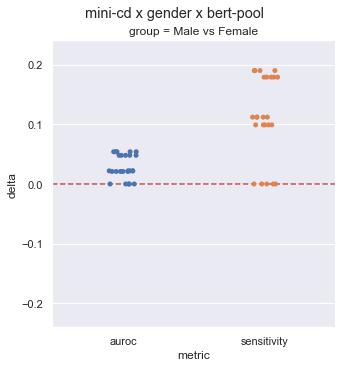

<Figure size 432x288 with 0 Axes>

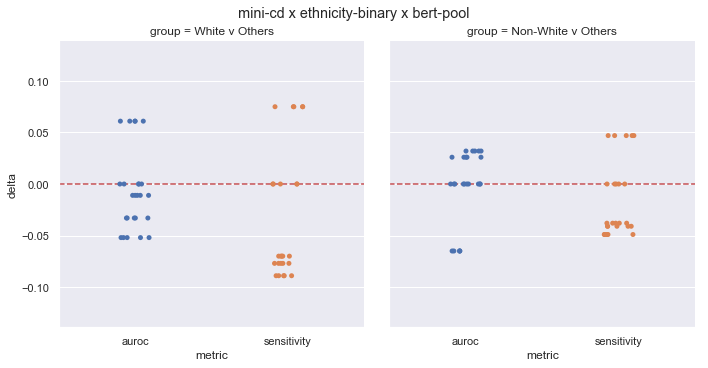

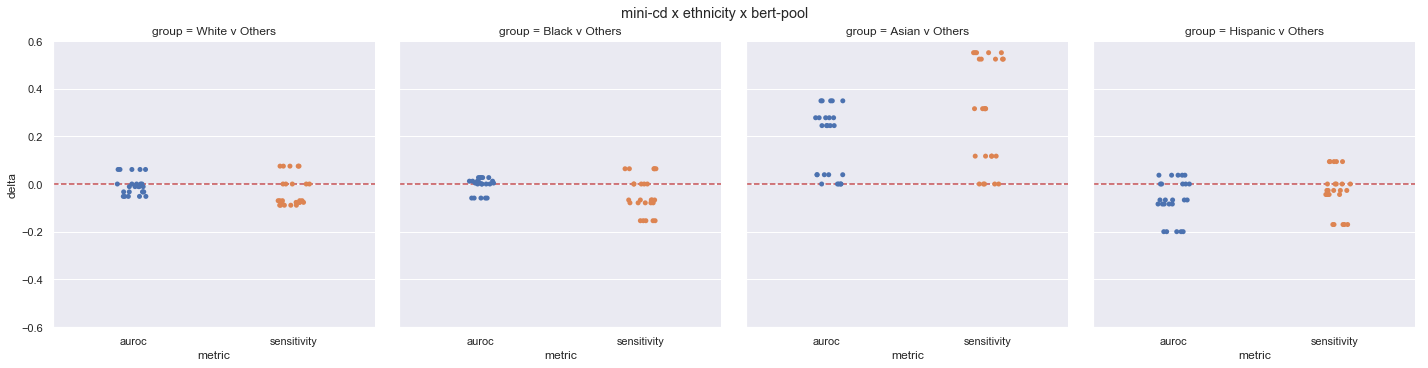

<Figure size 432x288 with 0 Axes>

In [17]:
dataset="CD"
dataset="mini-"+dataset
CLASSIFIER="sklearn"
run_analyses(INPUT_PATH, dataset, FEATURES_PATH, MODEL, OUTPUT_PATH, None, clear_results=False, tune_metric=None, subsample=False, plots=True)
# plot_analyses(OUTPUT_PATH, dataset, MODEL, dataset, tune_metric=None)

In [ ]:
CLASSIFIER="sklearn"
# run_analyses(INPUT_PATH, dataset, FEATURES_PATH, MODEL, OUTPUT_PATH, None, clear_results=False, tune_metric=None, subsample=False, plots=True)
plot_analyses(OUTPUT_PATH, dataset, MODEL, dataset, tune_metric=None)

In [ ]:
#Run tasks
run_tasks(INPUT_PATH, "tasks.txt", FEATURES_PATH, MODEL, OUTPUT_PATH, TMP_PATH, reset=True, tune_metric=None, subsample=False, mini_tasks=True)
plot_tasks(INPUT_PATH, "tasks.txt", MODEL, OUTPUT_PATH, mini_tasks=True, tune_metric=None)

In [ ]:
#Run tasks with subsampling
res_path = BASE_PATH+"/DATA/results_sub/"
cache_path = BASE_PATH+"/DATA/processed_sub/"
run_tasks(INPUT_PATH, "tasks.txt", FEATURES_PATH, MODEL, res_path, cache_path, reset=True, tune_metric=None, subsample=True, mini_tasks=True)
plot_tasks(INPUT_PATH, "tasks.txt", MODEL, res_path, mini_tasks=True, tune_metric=None)

In [ ]:
#Run tasks with tuning
TUNE_METRIC = "auprc"
run_tasks(INPUT_PATH, "tasks.txt", FEATURES_PATH, MODEL, TUNE_TMP_PATH, TUNE_OUTPUT_PATH, mini_tasks=True, reset=True, tune_metric=TUNE_METRIC)
# plot_tasks(INPUT_PATH, "tasks.txt", MODEL, TUNE_OUTPUT_PATH, mini_tasks=True, tune_metric=TUNE_METRIC)

# Scatter Plots

## Metrix x Metric

In [ ]:
#Plot all the metric scatter plots
with open(INPUT_PATH+"tasks.txt","r") as fid:
    for i,l in enumerate(fid):
        fname, task_name = l.strip("\n").split(",")
        # dataset = "mini-"+fname
        dataset = fname
        metric_scatter_plots(OUTPUT_PATH, dataset, MODEL, task_name)


## Performance x Delta

In [ ]:
#Plot all the performance scatter plots
with open(INPUT_PATH+"tasks.txt","r") as fid:
    for i,l in enumerate(fid):
        fname, task_name = l.strip("\n").split(",")
        # dataset = "mini-"+fname
        dataset = fname
        performance_scatter_plots(OUTPUT_PATH, dataset, MODEL, task_name)
